In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt
import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
from scipy import arange, cos, exp
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.patches as patches
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from haversine import haversine, Unit
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import rankdata


from matplotlib import colors as c
import csv
import pandas as pd

import matplotlib as mpl

import cc3d
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import matplotlib as mpl
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.colors import from_levels_and_colors
import random
import cmaps
from scipy import stats


# data load: land mask, time and spatial information, aridity index

In [11]:
NCname = '/Net/Groups/data_BGC/era5/e1/0d25_daily/t2mmax/t2mmax.daily.an.era5.1440.720.1950.nc'
NCData = Dataset(NCname)
lon_era5 = NCData.variables['longitude'][:]
lat_era5 = NCData.variables['latitude'][:]
LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
var = NCData.variables['t2mmax'][0]

time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
md_era5 = 100*np.array(mon_era5)+np.array(day_era5)
year_era5 = np.squeeze(np.array(year_era5)[md_era5!=229])
mon_era5 = np.squeeze(np.array(mon_era5)[md_era5!=229])
day_era5= np.squeeze(np.array(day_era5)[md_era5!=229])
NCData.close()


In [4]:
NCname = '/Net/Groups/BGI/scratch/yt/data/era5_land_surface_mask.nc'
NCData = Dataset(NCname)
land_mask = np.squeeze(NCData.variables['lsm'][:])
lon_era50 = NCData.variables['longitude'][:]
lat_era50 = NCData.variables['latitude'][:]
NCData.close()
land_mask = np.concatenate((land_mask[:,720:] ,land_mask[:,:720]),axis=1 )
lon_era50 = np.concatenate((lon_era50[720:]-360 ,lon_era50[:720]) )

In [5]:
LAT_era5[LAT_era5>np.nanmax(lat_era50)] = np.nanmax(lat_era50)
LAT_era5[LAT_era5<np.nanmin(lat_era50)] = np.nanmin(lat_era50)
LON_era5[LON_era5>np.nanmax(lon_era50)] = np.nanmax(lon_era50)
LON_era5[LON_era5<np.nanmin(lon_era50)] = np.nanmin(lon_era50)

In [6]:

my_interpolating_function = RegularGridInterpolator((lat_era50[::-1],lon_era50), land_mask[::-1])
land_mask  = my_interpolating_function((LAT_era5.ravel(), LON_era5.ravel())).reshape((len(LAT_era5[:,0]),len(LON_era5[0])))


In [30]:
year_era5_all = []
mon_era5_all = []
day_era5_all = []
for i_year in range(1979,2021):
    year_era5_all.extend(year_era5*0+i_year)
    mon_era5_all.extend(mon_era5)
    day_era5_all.extend(day_era5) 
year_era5_all = np.array(year_era5_all)   
mon_era5_all = np.array(mon_era5_all)   
day_era5_all = np.array(day_era5_all)   

In [19]:
def remove_seasonal(var):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [20]:
def remove_seasonal_normalized(var):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = (temp - np.array(len(temp)*[np.nanmean(temp,axis=0)]))/np.array(len(temp)*[np.nanstd(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [21]:
def SEB_ano(var,skt):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp1 =  np.array([skt[365*i_year+i_box] for i_year in range(42)])
        temp1 = np.array(len(temp1)*[np.nanmean(temp1,axis=0)])
        temp = temp/(4*5.68*1e-8*temp1**3)
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend

# data load: Heat wave event indices

In [22]:

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/')
leastdate = 5

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree')
HW_date = []
HW_lat = []
HW_lon = []
HW_location_lat = []
HW_location_lon = []
HW_duration = []
HW_aera = []
HW_date_centroid = []
HW_location_centroid = []
for fl in filelist:
    if fl[-4:] != '.csv':
        continue
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/' + fl
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            if i_row in [6,7,8]:
                all.append(np.array([ round(float(i)) for i in row]))
            else:
                all.append(np.array([ int(i) for i in row]))
    if all[5]<leastdate:
        continue
    if all[6]<40000:
        continue
    if   lat_era5[int(all[8][0])]<-23.5:
        if mon_era5_all[int(all[7])] not in [12,1,2]:
            continue
    if   lat_era5[int(all[8][0])]>=23.5:
        if mon_era5_all[int(all[7])] not in [6,7,8]:
            continue
    HW_date.append(all[0])
    HW_lat.append(all[1])
    HW_lon.append(all[2])
    HW_location_lat.append(all[3])
    HW_location_lon.append(all[4])   
    HW_duration.append(all[5])
    HW_aera.append(all[6])
    HW_date_centroid.append(all[7])
    HW_location_centroid.append(all[8])
    #print(all[0])
    #print(all[1])
    #print(all[2])
print(len(HW_date))
#%%
HW_duration = np.squeeze(np.array(HW_duration))
HW_aera = np.squeeze(np.array(HW_aera))
HW_date_centroid = np.squeeze(np.array(HW_date_centroid))
HW_location_centroid = np.squeeze(np.array( HW_location_centroid ))
#%%

3454


In [23]:
HW_duration = np.squeeze(np.array(HW_duration))
HW_aera = np.squeeze(np.array(HW_aera))
HW_date_centroid = np.squeeze(np.array(HW_date_centroid))
HW_location_centroid = np.squeeze(np.array( HW_location_centroid ))

HW_year = np.array([year_era5_all[i] for i in HW_date_centroid])
HW_mon = np.array([mon_era5_all[i] for i in HW_date_centroid])
HW_day = np.array([day_era5_all[i] for i in HW_date_centroid])

HW_center_lon = np.array([lon_era5[i] for i in HW_location_centroid[:,1]])
HW_center_lat = np.array([lat_era5[i] for i in HW_location_centroid[:,0]])

HW_location_lon = np.array([lon_era5[i] for i in HW_lon])
HW_location_lat = np.array([lat_era5[i] for i in HW_lat])

/tmp/ipykernel_1956346/2631722566.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_location_lon = np.array([lon_era5[i] for i in HW_lon])
/tmp/ipykernel_1956346/2631722566.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_location_lat = np.array([lat_era5[i] for i in HW_lat])


In [24]:
event_N = len(HW_duration)
print( 'extreme event n = ' +str(event_N))

extreme event n = 3454


In [25]:
HW_year_stat = []
for i in np.arange(1979,2020):
    HW_year_stat.append(len(np.array(HW_year)[np.array(HW_year)==i]))
HW_year_stat = np.array(HW_year_stat)

In [26]:
HW_year_stat_duration = []
for i in np.arange(1979,2020):
    HW_year_stat_duration.append(np.nanmean(np.array(HW_duration)[np.array(HW_year)==i]))
HW_year_stat_duration = np.array(HW_year_stat_duration)

In [27]:
HW_year_stat_area = []
for i in np.arange(1979,2020):
    HW_year_stat_area.append(np.nanmean(np.array(HW_aera)[np.array(HW_year)==i]))
HW_year_stat_area = np.array(HW_year_stat_area)

In [28]:
HW_year_max = np.array([year_era5_all[np.nanmax(i)] for i in HW_date])
HW_mon_max = np.array([mon_era5_all[np.nanmax(i)] for i in HW_date])
HW_day_max = np.array([day_era5_all[np.nanmax(i)] for i in HW_date])

HW_year_min = np.array([year_era5_all[np.nanmin(i)] for i in HW_date])
HW_mon_min = np.array([mon_era5_all[np.nanmin(i)] for i in HW_date])
HW_day_min = np.array([day_era5_all[np.nanmin(i)] for i in HW_date])

HW_day_duration_str = np.array([str(i)+'-'+str(j) for i,j in zip(HW_year_min*10000+HW_mon_min*100+HW_day_min,HW_year_max*10000+HW_mon_max*100+HW_day_max)])

In [31]:
HW_date_loc_all = np.array([ (i-np.nanmin(i))/(np.nanmax(i)-np.nanmin(i)) for i in HW_date])
HW_year_all = np.array([year_era5_all[i] for i in HW_date])
HW_mon_all = np.array([mon_era5_all[i] for i in HW_date])
HW_day_all = np.array([day_era5_all[i] for i in HW_date])
HW_ym = []
for i_year,i_mon in zip(HW_year_all ,HW_mon_all):
    i_ym = (i_year-1979)*12+i_mon
    HW_ym.append(i_ym)
HW_ym = np.array(HW_ym)

/tmp/ipykernel_1956346/3339976842.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_date_loc_all = np.array([ (i-np.nanmin(i))/(np.nanmax(i)-np.nanmin(i)) for i in HW_date])
/tmp/ipykernel_1956346/3339976842.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_year_all = np.array([year_era5_all[i] for i in HW_date])
/tmp/ipykernel_1956346/3339976842.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

# data load: SEB perturbation array


In [49]:
vername = '_235'
var = 'skt'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_skt_all = copy.deepcopy(all) 

var = 't2m'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_t2m_all = copy.deepcopy(all) 

var = 'ssr'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_ssr_all = copy.deepcopy(all)

#

var = 'strd'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_strd_all = copy.deepcopy(all)

#

var = 'sshf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_sshf_all = copy.deepcopy(all)

#

var = 'slhf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_slhf_all = copy.deepcopy(all)



flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_advection_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_advection_surface_new_all = copy.deepcopy(all)

flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_adiabatic_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_adiabatic_surface_new_all = copy.deepcopy(all)


HW_q_all = []  
for iii in range(len(HW_slhf_all)):
    HW_q_all.append(HW_skt_all[iii]-HW_ssr_all[iii]-HW_strd_all[iii]-HW_slhf_all[iii]-HW_sshf_all[iii])



In [33]:
var = 'skt_abs'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_skt_abs_all = copy.deepcopy(all) 

# pressure and new surface adv/adiabatic

In [ ]:
# HW_adiabatic_surface_new_all = []
# for i in range(event_N):
#     sp = HW_sp_abs_all[i]
#     temp_950  = HW_adiabatic_950_all[i]
#     temp_850 = HW_adiabatic_850_all[i]
#     temp_750 = HW_adiabatic_750_all[i]
#     temp_650 = HW_adiabatic_650_all[i]
#     temp = copy.deepcopy(temp_950 )
#     temp[(sp<90)&(sp>80)] = temp_850[(sp<90)&(sp>80)] 
#     temp[(sp<80)&(sp>70)] = temp_750[(sp<80)&(sp>70)]
#     temp[(sp<70)] = temp_650[(sp<70)]
#     HW_adiabatic_surface_new_all.append(temp)

# HW_advection_surface_new_all = []
# for i in range(event_N):
#     sp = HW_sp_abs_all[i]
#     temp_950  = HW_advection_950_all[i]
#     temp_850 = HW_advection_850_all[i]
#     temp_750 = HW_advection_750_all[i]
#     temp_650 = HW_advection_650_all[i]
#     temp = copy.deepcopy(temp_950 )
#     temp[(sp<90)&(sp>80)] = temp_850[(sp<90)&(sp>80)] 
#     temp[(sp<80)&(sp>70)] = temp_750[(sp<80)&(sp>70)]
#     temp[(sp<70)] = temp_650[(sp<70)]
#     HW_advection_surface_new_all.append(temp)
# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_advection_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_advection_surface_new_all)
#     print(var+'end')
# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_adiabatic_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_adiabatic_surface_new_all)
#     print(var+'end')

# Clustering with Kmeans

In [55]:

HW_SEB_all = []
HW_SEB_all1 = []
index_inlude = []
i_index = 0
for iii in range(len(HW_slhf_all)):
    SEB_event = np.array([ HW_advection_surface_new_all[iii],HW_adiabatic_surface_new_all[iii],HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
    
    for ii in  SEB_event:
        if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
            #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
            i_index = i_index + 1
            continue
            
        else:
            HW_SEB_all.append(np.array([ii/np.sum([np.abs(k) for k in ii])]))
            HW_SEB_all1.append(np.array(ii))
            index_inlude.append(i_index)
            i_index = i_index + 1
HW_SEB_all = np.squeeze( np.array(HW_SEB_all))
HW_SEB_all1 = np.squeeze( np.array(HW_SEB_all1))
index_inlude = np.array(index_inlude)

In [56]:
len(HW_SEB_all1)

8463177

In [109]:

# print('start kmeans n=4')
# km = KMeans(n_clusters=4, random_state=42)
# km.fit_predict(HW_SEB_all)
# HW_labels_all1 = km.labels_

# HW_labels_all = []

# nnn=0
# for iii in range(len(HW_slhf_all)):
#     HW_labels_temp = []
#     SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
#     for ii in  SEB_event:
#         if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
#             HW_labels_temp.append(np.nan)
#             continue
#         else:
#             HW_labels_temp.append(HW_labels_all1[nnn])
#             nnn=nnn+1
#     HW_labels_all.append(np.array(HW_labels_temp ))
# HW_labels_all = np.array(HW_labels_all)

In [110]:
# vername = '_235'
# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels_layer_near_sur'+vername+'.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_labels_all)
#     print('cluster end')

# Figure 1

# Clustering read

In [50]:
vername = '_235'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels_layer_near_sur'+vername+'.csv'
HW_labels_all1 = []
# HW_AI_all1 = []
HW_year_all1 = []
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        temp = []
        for i_i,i in enumerate(row):
            if np.isnan(float(i)):
                temp.append(np.nan)
                # HW_AI_all1.append(np.nan)
                HW_year_all1.append(np.nan)
            else:
                temp.append(round(float(i)))
                HW_labels_all1.append(round(float(i)))
                # HW_AI_all1.append(float(HW_AI_all[i_row][i_i]))
                HW_year_all1.append(float(HW_year_all[i_row][i_i]))
        all.append(np.array(temp))
HW_labels_all = copy.deepcopy(all)
HW_labels_all1 = np.array(HW_labels_all1)
# HW_AI_all1 = np.array(HW_AI_all1)
HW_year_all1 = np.array(HW_year_all1)


In [51]:
label_map = np.zeros((4,720,1440))
nn = 0
for i_k  in np.arange(event_N):
    # if HW_size_label[i_k]==1:
    #     continue
    xx = HW_lon[i_k]
    yy = HW_lat[i_k]
    zz = HW_labels_all[i_k]
    for i,j,k in zip(yy,xx,zz):
        label_map[k,i,j]=label_map[k,i,j]+1
    nn = nn+1

In [52]:

label_name = [1,3,0,2]

In [53]:
percentile = [(100*len(HW_labels_all1[HW_labels_all1==i_label])/len(HW_labels_all1)) for i_label in label_name]


In [66]:
Significance_all0 = []
for var_name in ['adv','adiabatic','ssr','strd','slhf','sshf','sshf']:
    Significance_all0.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily_revise.nc') ['__xarray_dataarray_variable__'][:][:]))
Significance_all0 = np.array(Significance_all0)


/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


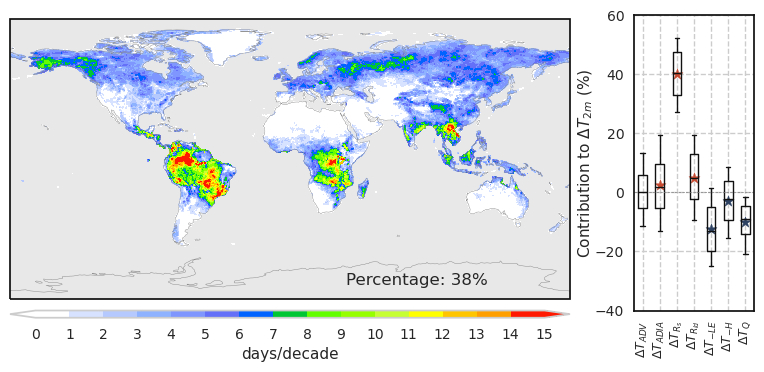

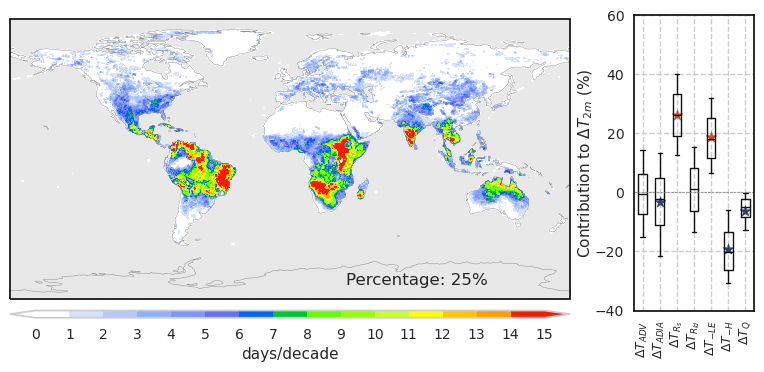

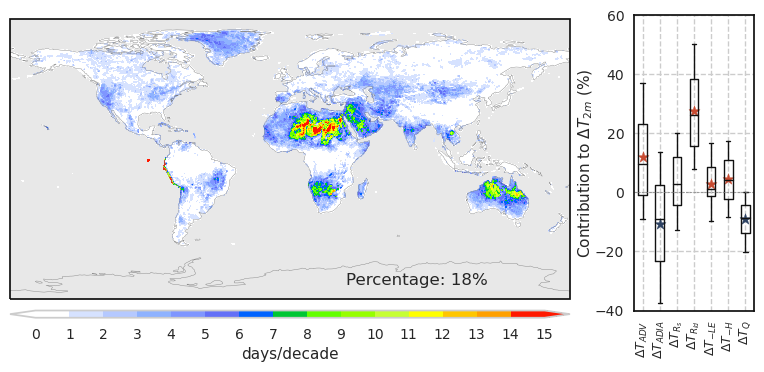

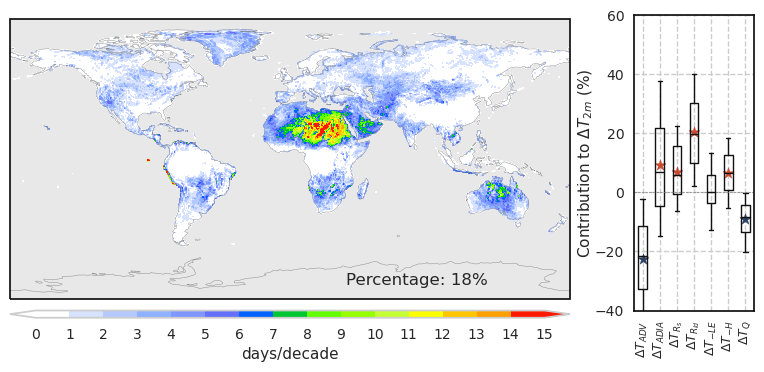

In [68]:
color_heat = '#c84b31'
color_cold = '#2d4263'

vername = '_235'
nn=0
for i_label,i_per,cmap in zip(label_name,percentile,[cm.Blues,cm.Oranges,cm.Greens,cm.Purples,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds]):
    nn=nn+1
    cmap =cmaps.precip3_16lev
    fig= plt.figure(figsize=(8, 3.6))
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.02, 0.17, 0.7, 0.8],projection = proj)
    ax.set_facecolor('#E8E8E8')
    ax.text(0.6, 0.05,'Percentage: %.0f'%i_per +'%',fontsize=12,transform=ax.transAxes)

    con_value = label_map[i_label]/4.2
    con_value[LAT_era5<-60]=np.nan
    con_value[land_mask<0.1]=np.nan

    levels = MaxNLocator(nbins=15).tick_values(0, 15)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    im = ax.contourf(LON_era5,LAT_era5, con_value, extend='both',levels=levels, cmap=cmap, norm=norm)
    ax.coastlines(color='grey')

    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent([-180, 180, -90, 90])

    rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')

    cax = plt.axes([0.02, 0.13, 0.7, 0.02])


    cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
    cbar.set_label('days/decade')
    cax.set_xticks(np.arange(0,16,1))
    cax.set_xticklabels(np.arange(0,16,1))
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.spines['geo'].set_color('k')
        
    ax = plt.axes([0.8, 0.15, 0.15, 0.82])


    bplot1 = ax.boxplot(np.array(HW_SEB_all)[HW_labels_all1==i_label]*100, positions=np.arange(1,8), whis = [10, 90],showfliers=False)

    scatter_plot = np.nanmean(HW_SEB_all[HW_labels_all1==i_label],axis=0)*100

    sig_max = np.nanmax( Significance_all0[:,i_label,:] ,axis=1)
    sig_min = np.nanmin( Significance_all0[:,i_label,:] ,axis=1)
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan

    ax.scatter(np.arange(1,8)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = '*',color=color_heat,s=70)
    ax.scatter(np.arange(1,8)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = '*',color=color_cold,s=70)
    ax.axhline(y = 0, color = 'grey', linestyle = '--',linewidth=0.5)
    ax.set_xticks(range(1,8))
    ax.set_xticklabels(['${\Delta}$$T_{ADV}$','${\Delta}$$T_{ADIA}$','${\Delta}$$T_{R_{s}}$','${\Delta}$$T_{R_{ld}}$','${\Delta}$$T_{-LE}$','${\Delta}$$T_{-H}$','${\Delta}$$T_{Q}$'],rotation=90,fontsize=9)    
    ax.set_ylabel('Contribution to $\Delta$$T_{2m}$ (%)',labelpad=0.1)
    ax.set_ylim(-40,60)


    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot1[element] :
            plt.setp(patch, color='k')

    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(linestyle='--')
    # fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_SOM_visit frequency'+str(nn)+vername+'.jpg', dpi=300)

# AI

In [69]:
# NCname = '/Net/Groups/BGI/scratch/yt/data/era5_mon/Potential-evaporation-total-precipitation.nc'
# NCData = Dataset(NCname)
# tp = NCData.variables['tp'][:]
# pev = -NCData.variables['pev'][:]
# pev[pev<0]=0
# tp[tp<0]=0
# time = NCData.variables['time']
# dates = list(num2date(time[:], time.units, time.calendar))
# year= np.array([date.year for date in dates])
# mon = np.array([date.month for date in dates])
# day = np.array([date.day for date in dates])
# md= 100*np.array(mon_era5)+np.array(day_era5)
# tp_mean = np.nanmean(tp,axis=0)[:-1,:]*12
# pev_mean = np.nanmean(pev,axis=0)[:-1,:]*12
# # plt.imshow(tp_mean,cmap='YlGnBu',vmax=0.1)
# # plt.colorbar()
# # plt.imshow(pev_mean,cmap='YlGnBu',vmax=0.1)
# # plt.colorbar()



In [ ]:
# AI_ERA5 = tp_mean /pev_mean
# AI_ERA5[(tp_mean<0.01)]=0
# AI_ERA5[(LAT_era5>70)]=np.nan
# AI_ERA5 = np.concatenate((AI_ERA5[:,720:],AI_ERA5[:,:720]),axis=1)
# AI_ERA5[land_mask<0.3]=np.nan

# indices_xr = xr.DataArray(np.array(AI_ERA5))
# indices_xr.to_netcdf('/Net/Groups/BGI/scratch/yt/data/era5_025_025/AI_ERA5.nc')

In [88]:
AI_ERA5 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/era5_025_025/AI_ERA5.nc') ['__xarray_dataarray_variable__'][:][:])


In [89]:
HW_AI_all = []
for i_lat,i_lon in zip(HW_lat,HW_lon):
    HW_AI_all.append(AI_ERA5[i_lat,i_lon])
    
vername = '_235'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels_layer_near_sur'+vername+'.csv'
HW_labels_all1 = []
HW_AI_all1 = []
HW_year_all1 = []
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        temp = []
        for i_i,i in enumerate(row):
            if np.isnan(float(i)):
                temp.append(np.nan)
                HW_AI_all1.append(np.nan)
                HW_year_all1.append(np.nan)
            else:
                temp.append(round(float(i)))
                HW_labels_all1.append(round(float(i)))
                HW_AI_all1.append(float(HW_AI_all[i_row][i_i]))
                HW_year_all1.append(float(HW_year_all[i_row][i_i]))
        all.append(np.array(temp))
HW_labels_all = copy.deepcopy(all)
HW_labels_all1 = np.array(HW_labels_all1)
HW_AI_all1 = np.array(HW_AI_all1)
HW_year_all1 = np.array(HW_year_all1)

HW_AI_all1[HW_AI_all1<0]=0
HW_AI_all1[HW_AI_all1>4]=4

/tmp/ipykernel_1956346/4232790242.py:61: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecat

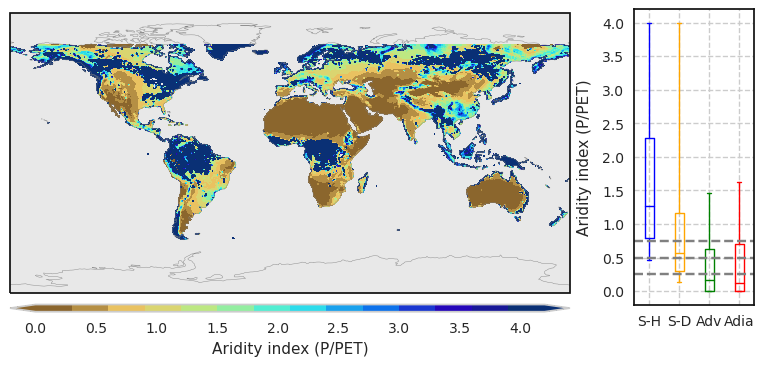

In [90]:

cmap =cmaps.GMT_drywet
fig= plt.figure(figsize=(8, 3.6))
proj = ccrs.PlateCarree(central_longitude=0)##
ax = plt.axes([0.02, 0.17, 0.7, 0.8],projection = proj)
ax.set_facecolor('#E8E8E8')

con_value = AI_ERA5
con_value[LAT_era5<-60]=np.nan
con_value[land_mask<0.1]=np.nan


levels = MaxNLocator(nbins=15).tick_values(0, 4)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = ax.contourf(LON_era5,LAT_era5, con_value, extend='both',levels=levels, cmap=cmap, norm=norm)
ax.coastlines(color='grey')

lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-180, 180, -90, 90])

rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)
cax = plt.axes([0.02, 0.13, 0.7, 0.02])


cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
cbar.set_label('Aridity index (P/PET)')
cax.set_xticks(np.arange(0,4.5,0.5))
cax.set_xticklabels(np.arange(0,4.5,0.5))
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.spines['geo'].set_color('k')



ax1 = plt.axes([0.8, 0.15, 0.15, 0.82])

plot_temp = HW_AI_all1

for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
    
    bplot = ax1.boxplot(plot_temp[HW_labels_all1==box_position][~np.isnan(plot_temp[HW_labels_all1==box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot[element] :
            plt.setp(patch, color=c)


ax1.axhline(y = 0.25, color = 'grey', linestyle = '--')
ax1.axhline(y = 0.5, color = 'grey', linestyle = '--')
ax1.axhline(y = 0.75, color = 'grey', linestyle = '--')

for bnd in ['bottom','top','right','left']:
    ax1.spines[bnd].set_color('k')  
ylabel0 = ax1.set_ylabel('Aridity index (P/PET)',labelpad=0.5) 
# ylabel0.set_position((0.5, 0.5))
ax1.grid(b=False)

ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)

ax1.yaxis.set_label_coords(-0.35, .5)


for element in ['whiskers','caps','medians','boxes']:
    for patch in bplot1[element] :
        plt.setp(patch, color='k')

for bnd in ['bottom','top','right','left']:
    ax1.spines[bnd].set_color('k')
ax1.grid(linestyle='--')
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/Type_map_AI.jpg', dpi=300)

# correlation T and SM

In [73]:
map_slope = np.load('/Net/Groups/BGI/scratch/yt/data/era5_025_025/T_SM_map_slope',allow_pickle=True)
map_r_value = np.load('/Net/Groups/BGI/scratch/yt/data/era5_025_025/T_SM_map_r_value',allow_pickle=True)
map_p_value = np.load('/Net/Groups/BGI/scratch/yt/data/era5_025_025/T_SM_map_p_value',allow_pickle=True)


In [74]:
HW_r_value_all = []
for i_lat,i_lon in zip(HW_lat,HW_lon):
    HW_r_value_all.append(map_r_value[i_lat,i_lon])
    
vername = '_235'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels_layer_near_sur'+vername+'.csv'
HW_labels_all1 = []
HW_r_value_all1 = []
HW_year_all1 = []
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        temp = []
        for i_i,i in enumerate(row):
            if np.isnan(float(i)):
                temp.append(np.nan)
                HW_r_value_all1.append(np.nan)
                HW_year_all1.append(np.nan)
            else:
                temp.append(round(float(i)))
                HW_labels_all1.append(round(float(i)))
                HW_r_value_all1.append(float(HW_r_value_all[i_row][i_i]))
                HW_year_all1.append(float(HW_year_all[i_row][i_i]))
        all.append(np.array(temp))
HW_labels_all = copy.deepcopy(all)
HW_labels_all1 = np.array(HW_labels_all1)
HW_r_value_all1 = np.array(HW_r_value_all1)
HW_year_all1 = np.array(HW_year_all1)

# HW_r_value_all1[HW_r_value_all1<0]=0
# HW_r_value_all1[HW_r_value_all1>4]=4

/tmp/ipykernel_1956346/823136626.py:58: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecatio

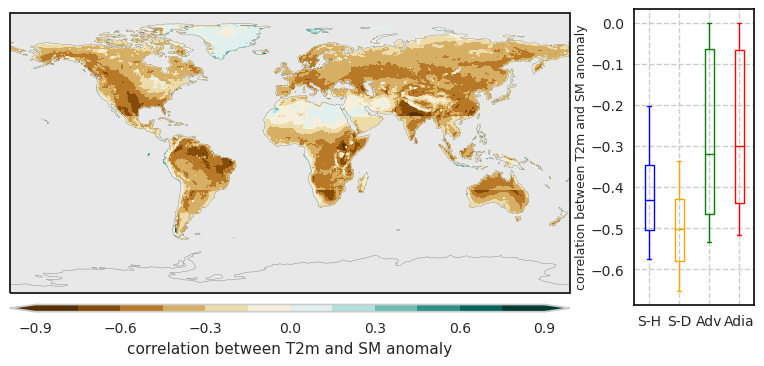

In [75]:

cmap =cmaps.MPL_BrBG
fig= plt.figure(figsize=(8, 3.6))
proj = ccrs.PlateCarree(central_longitude=0)##
ax = plt.axes([0.02, 0.17, 0.7, 0.8],projection = proj)
ax.set_facecolor('#E8E8E8')

con_value = map_r_value
con_value[LAT_era5<-60]=np.nan
con_value[land_mask<0.1]=np.nan

levels = MaxNLocator(nbins=15).tick_values(-0.8, 0.8)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = ax.contourf(LON_era5,LAT_era5, con_value, extend='both',levels=levels, cmap=cmap, norm=norm)
ax.coastlines(color='grey')

lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-180, 180, -90, 90])

rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')

cax = plt.axes([0.02, 0.13, 0.7, 0.02])


cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
cbar.set_label('correlation between T2m and SM anomaly')

for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.spines['geo'].set_color('k')
    
ax = plt.axes([0.8, 0.15, 0.15, 0.82])

plot_temp = HW_r_value_all1


for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
    
    bplot = ax.boxplot(plot_temp[HW_labels_all1==box_position][~np.isnan(plot_temp[HW_labels_all1==box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot[element] :
            plt.setp(patch, color=c)


# ax.axhline(y = 0.25, color = 'grey', linestyle = '--')
# ax.axhline(y = 0.5, color = 'grey', linestyle = '--')
# ax.axhline(y = 0.75, color = 'grey', linestyle = '--')

for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')  
ylabel = ax.set_ylabel('correlation between T2m and SM anomaly',fontsize=9) 

ax.grid(b=False)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)

ax.yaxis.set_label_coords(-.38, .5)


for element in ['whiskers','caps','medians','boxes']:
    for patch in bplot1[element] :
        plt.setp(patch, color='k')

for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.grid(linestyle='--')
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/Type_map_corr_T_SM.jpg', dpi=300)

# Figure 2

# Attribution

In [160]:
vername = '_235'
Significance_all1 = []
for var_name in ['z500','tcc']:
    Significance_all1.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily.nc') ['__xarray_dataarray_variable__'][:][:]))
for var_name in ['swvl1']:
    Significance_all1.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily_revise.nc') ['__xarray_dataarray_variable__'][:][:]))

Significance_all1 = np.array(Significance_all1)
Significance_all1[0] = Significance_all1[0]/100
Significance_all1[1] = Significance_all1[1]*100
Significance_all1[2] = Significance_all1[2]*1000


Significance_all2 = []
for var_name in ['u_dT','du_T','v_dT','dv_T']:
    Significance_all2.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily.nc') ['__xarray_dataarray_variable__'][:][:]))
for var_name in ['omega']:
    Significance_all2.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily_revise.nc') ['__xarray_dataarray_variable__'][:][:]))

Significance_all2 = np.array(Significance_all2)

Significance_all21 = np.array([np.array(Significance_all2[0])+np.array(Significance_all2[1]),np.array(Significance_all2[2])+np.array(Significance_all2[3]),Significance_all2[4]])

In [78]:
vername = '_235'
var = 'z500'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_downscale.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])/100)
HW_z500_all = copy.deepcopy(all)

var = 'tcc'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])*100)
HW_tcc_all = copy.deepcopy(all)



var = 'swvl1'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])*1000)
HW_swvl1_all = copy.deepcopy(all)



In [79]:
# def cal_sur_new(var0,HW_sp_abs_all,event_N):

#     var = var0+'650'
#     flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
#     with open(flname, 'r') as file:
#         reader = csv.reader(file)
#         all = []
#         for i_row,row in enumerate(reader):
#             all.append(np.array([float(i) for i in row]))
#     all_650 = copy.deepcopy(all)

#     var = var0+'750'
#     flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
#     with open(flname, 'r') as file:
#         reader = csv.reader(file)
#         all = []
#         for i_row,row in enumerate(reader):
#             all.append(np.array([float(i) for i in row]))
#     all_750 = copy.deepcopy(all)

#     var = var0+'850'
#     flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
#     with open(flname, 'r') as file:
#         reader = csv.reader(file)
#         all = []
#         for i_row,row in enumerate(reader):
#             all.append(np.array([float(i) for i in row]))
#     all_850 = copy.deepcopy(all)

#     var = var0+'950'
#     flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
#     with open(flname, 'r') as file:
#         reader = csv.reader(file)
#         all = []
#         for i_row,row in enumerate(reader):
#             all.append(np.array([float(i) for i in row]))
#     all_950 = copy.deepcopy(all)

#     all_surface_new_all = []
#     for i in range(event_N):
#         sp = HW_sp_abs_all[i]
#         temp_950  = all_950[i]
#         temp_850 = all_850[i]
#         temp_750 = all_750[i]
#         temp_650 = all_650[i]
#         temp = copy.deepcopy(temp_950 )
#         temp[(sp<90)&(sp>80)] = temp_850[(sp<90)&(sp>80)] 
#         temp[(sp<80)&(sp>70)] = temp_750[(sp<80)&(sp>70)]
#         temp[(sp<70)] = temp_650[(sp<70)]
#         all_surface_new_all.append(temp)
#     return all_surface_new_all
# HW_omega_all = cal_sur_new('omega_',HW_sp_abs_all,event_N)
# HW_dv_T_all = cal_sur_new('dv_T',HW_sp_abs_all,event_N)
# HW_du_T_all = cal_sur_new('du_T',HW_sp_abs_all,event_N)
# HW_v_dT_all = cal_sur_new('v_dT',HW_sp_abs_all,event_N)
# HW_u_dT_all = cal_sur_new('u_dT',HW_sp_abs_all,event_N)

# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_omega_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_omega_all)

# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_dv_T_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_dv_T_all)

# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_du_T_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_du_T_all)


# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_v_dT_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_v_dT_all)


# with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_u_dT_surface_ano_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(HW_u_dT_all)

In [148]:

var = 'dv_T'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_dv_T_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_dv_T_all = copy.deepcopy(all)

var = 'du_T'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_du_T_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_du_T_all = copy.deepcopy(all)

var = 'v_dT'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_v_dT_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_v_dT_all = copy.deepcopy(all)

var = 'u_dT'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_u_dT_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_u_dT_all = copy.deepcopy(all)


flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_omega_surface_ano_all.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_omega_all = copy.deepcopy(all)

In [85]:
var_map1 = []
for var_all in [HW_z500_all,HW_tcc_all,HW_swvl1_all]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):

        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue

            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    temp_map 
    var_map1.append(temp_map)
    
var_map2 = []
for var_all in [HW_u_dT_all+HW_v_dT_all,HW_du_T_all+HW_dv_T_all,HW_omega_all]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
 
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    var_map2.append(temp_map)

[9.79597877 3.00001642 5.26852152 5.31987601]
[-30.31100802 -21.95692852   2.61482806  -2.35659805]


/tmp/ipykernel_1956346/811323228.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/tmp/ipykernel_1956346/811323228.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[-63.79521974 -89.52891038          nan          nan]


/tmp/ipykernel_1956346/811323228.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


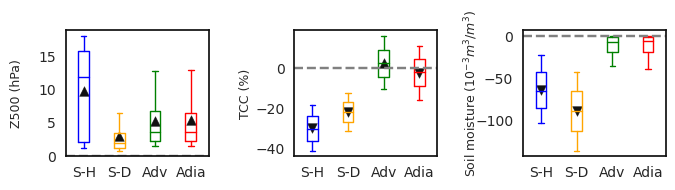

In [113]:

fig,axs = plt.subplots(figsize=(7.5, 2),ncols=3,nrows=1)
for var_number,ylabel in zip(range(4),['Z500 (hPa)','TCC (%)','Soil moisture ($10^{-3}$$m^{3}$/$m^{3}$)']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map1[var_number])
    plot_temp[label_map <10] = np.nan


    all_data = []
    for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
        all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
        bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
        for element in ['whiskers','caps','medians','boxes']:
            for patch in bplot[element] :
                plt.setp(patch, color=c)

    
    all_data = np.array(all_data)
    scatter_plot = all_data
    sig_max = np.nanmax( Significance_all1[var_number,:,:] ,axis=1)[label_name]
    sig_min = np.nanmin( Significance_all1[var_number,:,:] ,axis=1)[label_name]
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan

    print(scatter_plot)
    ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
    ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')
    ax.axhline(y = 0, color = 'grey', linestyle = '--')



    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(b=False)

    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)
    ax.yaxis.set_label_coords(-.3, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_disbalance_hydro_box.jpg', dpi=300)

[        nan         nan  0.00579549 -0.00767981]
[0.00470988        nan 0.008713          nan]


/tmp/ipykernel_1956346/1035540954.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/tmp/ipykernel_1956346/1035540954.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[        nan         nan -0.05439918  0.05131186]


/tmp/ipykernel_1956346/1035540954.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


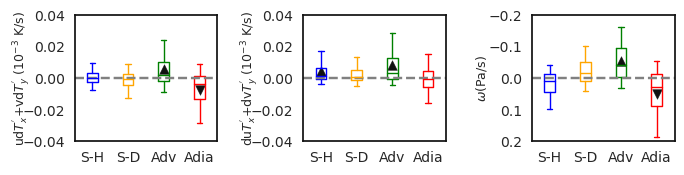

In [161]:



fig,axs = plt.subplots(figsize=(7.5, 2),ncols=3,nrows=1)
for var_number,ylabel in zip(range(4),['ud$T^{\'}_x$+vd$T^{\'}_y$ ($10^{-3}$ K/s)','du$T^{\'}_x$+dv$T^{\'}_y$ ($10^{-3}$ K/s)','${\omega}$(Pa/s)']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map2[var_number])

    all_data = []
    for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
        all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
        bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
        for element in ['whiskers','caps','medians','boxes']:
            for patch in bplot[element] :
                plt.setp(patch, color=c)

    
    all_data = np.array(all_data)
    scatter_plot = all_data
    sig_max = np.nanmax( Significance_all21[var_number,:,:] ,axis=1)[label_name]
    sig_min = np.nanmin( Significance_all21[var_number,:,:] ,axis=1)[label_name]
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan


    print(scatter_plot)
    ax.axhline(y = 0, color = 'grey', linestyle = '--')



    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(b=False)

    if var_number==2:
        ax.set_ylim(-0.2,0.2)
        ax.invert_yaxis()
        ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "v",color='k')
        ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "^",color='k')
    else:
        ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
        ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')      
        ax.set_ylim(-0.04,0.04)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)
    ax.yaxis.set_label_coords(-.3, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_disbalance_metero_box.jpg', dpi=300)

# Figure 3

# Impact on carbon cycle monthly_detrend

In [162]:
Significance_all3 = []
for var_name in ['NEE','TER','GPP']:
    Significance_all3.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_monthly'+vername+'_detrend_weighted.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all3 = np.array(Significance_all3)

Significance_all3[0] = Significance_all3[0]
Significance_all3[1] = Significance_all3[1]
Significance_all3[2] = Significance_all3[2]


In [163]:

var = 'GPP'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_GPP_all1 = copy.deepcopy(all)

var = 'TER'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_TER_all1 = copy.deepcopy(all)

var = 'NEE'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_NEE_all1 = copy.deepcopy(all)


In [164]:
var_map3 = []
for var_all in [ HW_NEE_all1,HW_GPP_all1,HW_TER_all1]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    var_map3.append(temp_map)

In [165]:
f_map_new = copy.deepcopy(f_map)
f_map_new[f_map_new>=1]=1
f_map_new = np.nansum(f_map_new,axis=0)

var_map3_new = []
for i_var in var_map3:
    temp = []
    for j_var in i_var:
        j_var_new = copy.deepcopy(j_var)
        j_var_new[f_map_new<4]=np.nan
        temp.append(j_var_new)
    var_map3_new.append(np.array(temp))

In [166]:
len(np.array(var_map3_new) [np.array(var_map3_new) >0])

456769

In [167]:
len(np.array(var_map3) [np.array(var_map3) >0])

1027824

In [168]:
var_map3 = var_map3_new

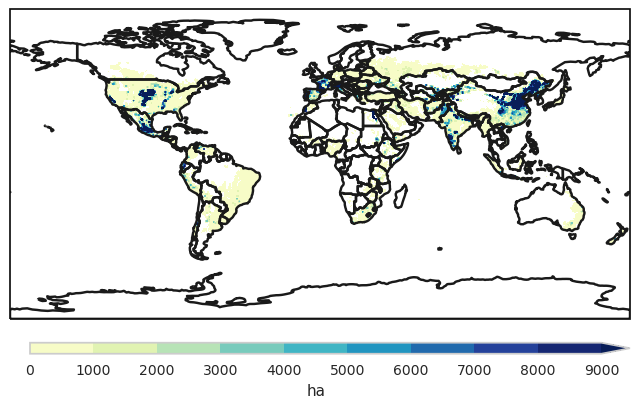

In [169]:
HA_grid = np.loadtxt('/Net/Groups/BGI/scratch/yt/data/harvested_area_grids/annual_area_harvested_irc_crop02_ha_30mn.asc', skiprows=6)
a = np.zeros_like(LON_era5)


a[::2,::2]=HA_grid[:,:]
a[::2,1::2]=HA_grid[:,:]

a[1::2,::2]=HA_grid[:,:]
a[1::2,1::2]=HA_grid[:,:]


a[a<=0]=np.nan

area = copy.deepcopy(a)

import regionmask

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.arange(0,10000,1000),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.arange(0,10000,1000))
cbar.set_label('ha')
#cbar.set_xticks(levels=np.hstack([10,np.arange(100,1100,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
#plt.colorbar(con)
area_h = copy.deepcopy(a)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
ax.spines['geo'].set_color('k')
f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/harvest_area.jpg', dpi=300)

In [170]:
a_all = []
for i in range(4):
    a_all.append(area_h)
a_all = np.array(a_all)

[-0.03662162 -0.06495933 -0.03419829 -0.03170224]
[-0.04760186 -0.08458128 -0.04663862 -0.03981649]


/tmp/ipykernel_1956346/1357798611.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[-0.05825624 -0.12863843 -0.05723558 -0.05561917]
[-0.08276952 -0.16155104 -0.08151987 -0.07797957]
[-0.02348509 -0.05782734 -0.02302286 -0.02270925]


/tmp/ipykernel_1956346/1357798611.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[-0.03360681 -0.06822276 -0.03370594 -0.03482735]


/tmp/ipykernel_1956346/1357798611.py:54: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


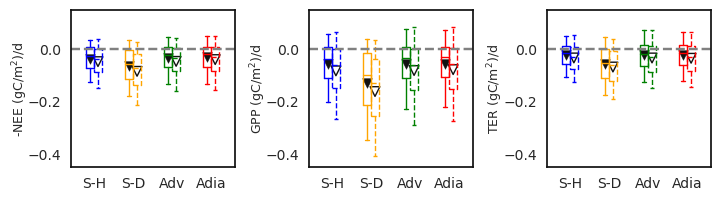

In [171]:

fig,axs = plt.subplots(figsize=(8, 2.5),ncols=3,nrows=1)
for var_number,ylabel in zip(range(3), ['-NEE (gC/m$^2$)/d','GPP (gC/m$^2$)/d','TER (gC/m$^2$)/d']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map3[var_number])
    # plot_temp[label_map <10] = np.nan
    plot_temp = plot_temp 
    plot_temp1 = copy.deepcopy(plot_temp)
    plot_temp2 = copy.deepcopy(plot_temp)
    plot_temp2[np.isnan(a_all )]=np.nan

    for nn,plot_temp,pos_all,ln in zip([0,1],[plot_temp1,plot_temp2],[np.arange(0,4)-0.1,np.arange(0,4)+0.1],['-','--']):
        if var_number==0:
            plot_temp = -plot_temp
            
        all_data = []
        for pos,box_position,c in zip(pos_all,label_name,['blue','orange','green','red']):
            all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
            bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.2, positions=[pos+1],whis = [10, 90],showfliers=False)
            for element in ['whiskers','caps','medians','boxes']:
                for patch in bplot[element] :
                    plt.setp(patch, color=c,linestyle=ln)

        
        all_data = np.array(all_data)
        scatter_plot = copy.deepcopy(all_data)

        sig_max = np.nanmax( Significance_all3[var_number,:,:] ,axis=1)[label_name]
        sig_min = np.nanmin( Significance_all3[var_number,:,:] ,axis=1)[label_name]
        scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan


        print(scatter_plot)
        if nn==0:
            ax.scatter(pos_all[scatter_plot>0]+1,scatter_plot[scatter_plot>0],marker = "^",color='k')
            ax.scatter(pos_all[scatter_plot<0]+1,scatter_plot[scatter_plot<0],marker = "v",color='k')
        else:
            ax.scatter(pos_all[scatter_plot>0]+1,scatter_plot[scatter_plot>0],marker = "^",edgecolor='k',facecolor='none',linewidth=1)
            ax.scatter(pos_all[scatter_plot<0]+1,scatter_plot[scatter_plot<0],marker = "v",edgecolor='k',facecolor='none',linewidth=1)
                
    ax.axhline(y = 0, color = 'grey', linestyle = '--')



    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 

    ax.grid(b=False)

    
    
    ax.set_ylim(-0.45,0.15)


    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)


    ax.yaxis.set_label_coords(-.25, .5)
    
plt.subplots_adjust(wspace=0.45,bottom=0.25,left=0.15,right=0.95)
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_carbon_box.jpg', dpi=300)

# Impact on human daily_detrend

In [172]:
import regionmask
NCname = r'/Net/Groups/BGI/scratch/yt/data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_1_deg_nc/gpw_v4_population_density_adjusted_rev11_1_deg.nc'
NCData = Dataset(NCname)
lon_PD = NCData.variables['longitude'][:]
lat_PD = NCData.variables['latitude'][:]
LON_PD, LAT_PD = np.meshgrid(lon_PD, lat_PD)
PD = NCData.variables['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree'][:]
PD[PD<0] = np.nan

a = np.zeros_like(LON_era5)


a[::4,::4]=PD[4][:,:]
a[::4,1::4]=PD[4][:,:]
a[::4,2::4]=PD[4][:,:]
a[::4,3::4]=PD[4][:,:]

a[1::4,::4]=PD[4][:,:]
a[1::4,1::4]=PD[4][:,:]
a[1::4,2::4]=PD[4][:,:]
a[1::4,3::4]=PD[4][:,:]

a[2::4,::4]=PD[4][:,:]
a[2::4,1::4]=PD[4][:,:]
a[2::4,2::4]=PD[4][:,:]
a[2::4,3::4]=PD[4][:,:]

a[3::4,::4]=PD[4][:,:]
a[3::4,1::4]=PD[4][:,:]
a[3::4,2::4]=PD[4][:,:]
a[3::4,3::4]=PD[4][:,:]




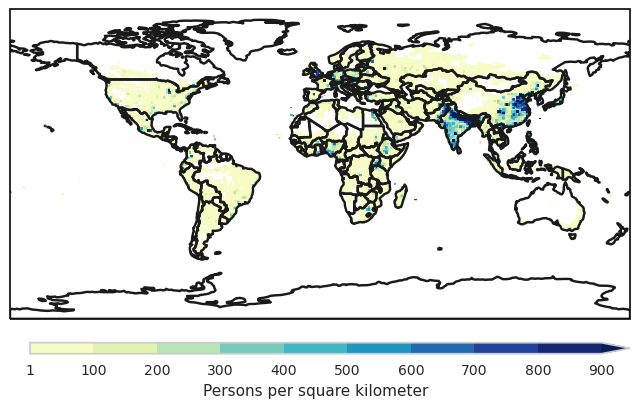

In [173]:
a[a<1]=np.nan
a[land_mask<0.1]=np.nan

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.hstack([1,np.arange(100,1000,100)]),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.hstack([1,np.arange(100,1000,100)]))
cbar.set_label('Persons per square kilometer')
#cbar.set_xticks(levels=np.hstack([1,np.arange(100,1000,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
area = copy.deepcopy(a)
ax.spines['geo'].set_color('k')

f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/population_density.jpg', dpi=300)

In [174]:
Significance_all4 = []
for var_name in ['utci','t2m','rH_cf']:
    Significance_all4.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily_detrend.nc') ['__xarray_dataarray_variable__'][:][:]))

Significance_all4 = np.array(Significance_all4)

In [175]:
vername = '_235'


var = 'rH_cf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_rH_cf_all = copy.deepcopy(all)

var = 'tsi'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_HSI_all = copy.deepcopy(all)



var = 't2m'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_t2m_all = copy.deepcopy(all)

In [176]:
var_map4 = []
for var_all in  [HW_HSI_all,HW_t2m_all,HW_rH_cf_all]:

    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            if (kk>100)|(kk<-100):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    temp_map 
    var_map4.append(temp_map)

In [177]:
var_map41 = copy.deepcopy(np.array([var_map4[0],var_map4[1],var_map4[2]]))

In [178]:
f_map_new = copy.deepcopy(f_map)
f_map_new[f_map_new>=1]=1
f_map_new = np.nansum(f_map_new,axis=0)

var_map41_new = []
for i_var in var_map41:
    temp = []
    for j_var in i_var:
        j_var_new = copy.deepcopy(j_var)
        j_var_new[f_map_new<4]=np.nan
        temp.append(j_var_new)
    var_map41_new.append(np.array(temp))

In [179]:
var_map41 =    var_map41_new

In [180]:
a_all1 = []
for i in range(4):
    a_all1.append(a)
a_all1 = np.array(a_all1)

[5.63019167 5.7684418  6.17282744 5.83321279]
[4.63407406 4.76317308 5.53716835 5.11682243]


/tmp/ipykernel_1956346/3640145257.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[5.11846178 5.21132642 5.39611901 5.35351583]
[4.49499093 4.70235165 4.94527521 4.83571817]


/tmp/ipykernel_1956346/3640145257.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[-13.02163169 -15.70303577  -7.30436971  -8.45899864]
[-13.14680197 -16.12020052  -7.89753169  -8.95822   ]


/tmp/ipykernel_1956346/3640145257.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


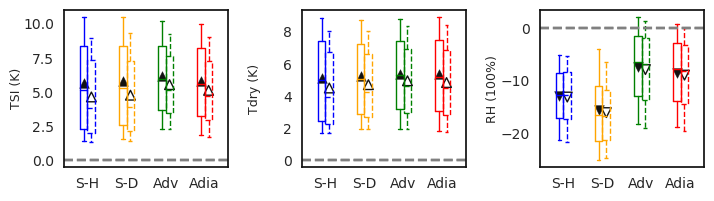

In [181]:

fig,axs = plt.subplots(figsize=(8, 2.5),ncols=3,nrows=1)
for var_number,ylabel in zip(range(4),['TSI (K)','Tdry (K)','RH (100%)']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map41[var_number])

    plot_temp1 = copy.deepcopy(plot_temp)
    plot_temp2 = copy.deepcopy(plot_temp)
    plot_temp2[np.isnan(a_all1)] = np.nan

    for nn,plot_temp,pos_all,ln in zip([0,1],[plot_temp1,plot_temp2],[np.arange(0,4)-0.1,np.arange(0,4)+0.1],['-','--']):
      
        all_data = []
        for pos,box_position,c in zip(pos_all,label_name,['blue','orange','green','red']):
            all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
            bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.2, positions=[pos+1],whis = [10, 90],showfliers=False)
            for element in ['whiskers','caps','medians','boxes']:
                for patch in bplot[element] :
                    plt.setp(patch, color=c,linestyle=ln)

        
        all_data = np.array(all_data)
        scatter_plot = all_data
        
        sig_max = np.nanmax( Significance_all4[var_number,:,:] ,axis=1)[label_name]
        sig_min = np.nanmin( Significance_all4[var_number,:,:] ,axis=1)[label_name]
        

        scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan
        if nn==0:
            ax.scatter(pos_all[scatter_plot>0]+1,scatter_plot[scatter_plot>0],marker = "^",color='k')
            ax.scatter(pos_all[scatter_plot<0]+1,scatter_plot[scatter_plot<0],marker = "v",color='k')
        else:
            ax.scatter(pos_all[scatter_plot>0]+1,scatter_plot[scatter_plot>0],marker = "^",edgecolor='k',facecolor= 'none',linewidth=1)
            ax.scatter(pos_all[scatter_plot<0]+1,scatter_plot[scatter_plot<0],marker = "v",edgecolor='k',facecolor= 'none',linewidth=1)          
        ax.axhline(y = 0, color = 'grey', linestyle = '--')
        print(scatter_plot)


    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 

    ax.grid(b=False)


    

    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)


    ax.yaxis.set_label_coords(-.25, .5)
plt.subplots_adjust(wspace=0.45,bottom=0.25,left=0.15,right=0.95)
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_Human_impact_daily_box.jpg', dpi=300)

# Figure 4

# change map

In [183]:
label_map_part1 = np.zeros((4,720,1440))
label_map_part2 = np.zeros((4,720,1440))

for i_k  in np.arange(event_N):
    # if HW_size_label[i_k]==1:
    #     continue
    xx = HW_lon[i_k]
    yy = HW_lat[i_k]
    zz = HW_labels_all[i_k]
    i_year = HW_year_all[i_k]
    if (i_year<2000).any():
        for i,j,k in zip(yy,xx,zz):
            label_map_part1[k,i,j]=label_map_part1[k,i,j]+1
    elif (i_year>=2000).any():
        for i,j,k in zip(yy,xx,zz):
            label_map_part2[k,i,j]=label_map_part2[k,i,j]+1        


In [184]:
label_map_part1_new = np.zeros((4,720,1440))
for i in range(4):
    label_map_part1_new[i]=label_map_part1[label_name[i]]
label_map_part1_new.dump(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/label_map_layer_near_sur_part1'+vername+'.csv')

label_map_part2_new = np.zeros((4,720,1440))
for i in range(4):
    label_map_part2_new[i]=label_map_part2[label_name[i]]
label_map_part2_new.dump(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/label_map_layer_near_sur_part2'+vername+'.csv')


In [185]:
for i_label in label_name:
    print(len(HW_labels_all1[(HW_labels_all1==i_label)&(np.in1d(HW_year_all1,range(1979,2000)))]))

873312
579984
407445
411894


In [186]:
color_heat = '#c84b31'
color_cold = '#2d4263'

/tmp/ipykernel_1956346/858163059.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("precip3_16lev").copy()
  cmap.set_under('white')


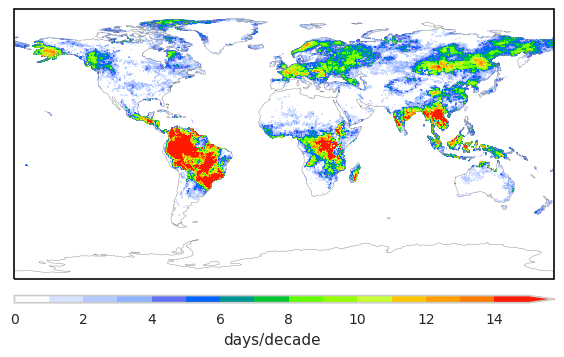

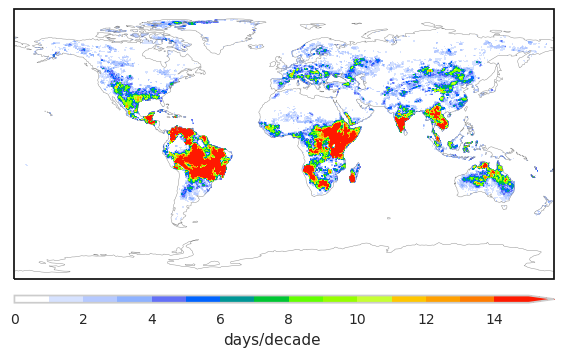

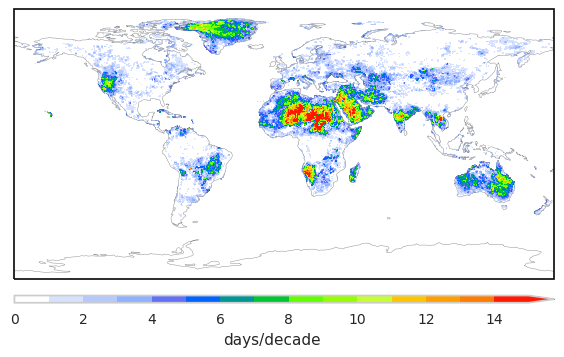

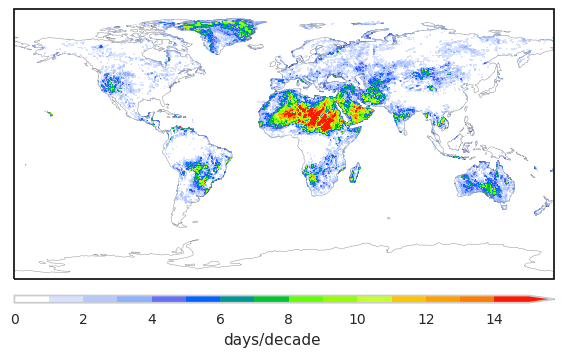

In [199]:
vername = '_235'
nn=0
for i_label,cmap,map_name in zip(label_name,[cm.Blues,cm.Oranges,cm.Greens,cm.Purples,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds],['S-H','S-D','ADV','ADIA']):
    nn=nn+1
    cmap =cmaps.precip3_16lev
    # cmap =cm.RdBu_r
    # cmap = cmaps.BlueWhiteOrangeRed
    cmap.set_under('white')
    fig= plt.figure(figsize=(6, 3.6))
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.02, 0.17, 0.9, 0.8],projection = proj)
    # ax.set_facecolor('#E8E8E8')
    # ax.text(0.6, 0.05,'Percentage: %.2f' % (100*len(HW_labels_all1[(HW_labels_all1==i_label)&(np.in1d(HW_year_all1,range(2011,2021)))])/len(HW_labels_all1[(np.in1d(HW_year_all1,range(2011,2021)))]))+'%',fontsize=12,transform=ax.transAxes)
    # ax.text(0.6, 0.05,'Percentage: %.2f' % (100*len(HW_labels_all1[(HW_labels_all1==i_label)&(np.in1d(HW_year_all1,range(2011,2021)))])/len(HW_labels_all1[(np.in1d(HW_year_all1,range(2011,2021)))]))+'%',fontsize=12,transform=ax.transAxes)

    con_value = (label_map_part2[i_label]-label_map_part1[i_label])/2.1
    con_value[LAT_era5<-60]=np.nan
    con_value[land_mask<0.1]=np.nan
    #con_value[con_value==0]=0
    #cmap = cm.Blues
    #cmap.set_bad('white',0)
    #cmap.set_bad('#F0F0F0',np.nan)
    
    #con  = ax.contourf(LON_era5,LAT_era5,con_value,cmap=cmap)
    levels = MaxNLocator(nbins=15).tick_values(0, 15)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # levels = np.arange(-2,2.1,0.1)
    #im = ax.pcolormesh(LON_era5,LAT_era5, con_value, cmap=cmap, norm=norm)
  
    im = ax.contourf(LON_era5,LAT_era5, con_value, extend='max',levels=levels, cmap=cmap)
    # im =ax.imshow(con_value,cmaps.BlueWhiteOrangeRed,vmax=3,vmin=-3)
    ax.coastlines(color='grey')
    # ax.gridlines()
    # ax.set_xticks([-180, -120, -60,0, 60, 120, 180, ], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent([-180, 180, -90, 90])

    rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')
    #ax.add_patch(rect)
    cax = plt.axes([0.02, 0.13, 0.9, 0.02])

    #ax1.grid(b=False)

    cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
    cbar.set_label('days/decade')
    # cax.set_xticks(np.arange(-2,2.1,0.1))
    # cax.set_xticklabels(np.arange(-2,2.1,0.1))
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.spines['geo'].set_color('k')
        
        
    # fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/HW_visit frequency_'+map_name+'_delta_new_experience.jpg', dpi=300)
    # fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_visit frequency'+str(nn)+vername+'.jpg', dpi=300)

# change statistic

In [188]:
area_weight = np.zeros_like(land_mask)

for i in range(land_mask.shape[0]-1):
    for j in range(land_mask.shape[1]-1):
        dis1 =  haversine((0, 0), (0.25, 0), unit='km')
        dis2 =  haversine((LAT_era5[:,0][i], 0), (LAT_era5[:,0][i], 0.25), unit='km')
        area_weight[i,j]=dis1*dis2

area_weight[-1,:]=area_weight[-2,:]
area_weight[:,-1]=area_weight[:,-2]

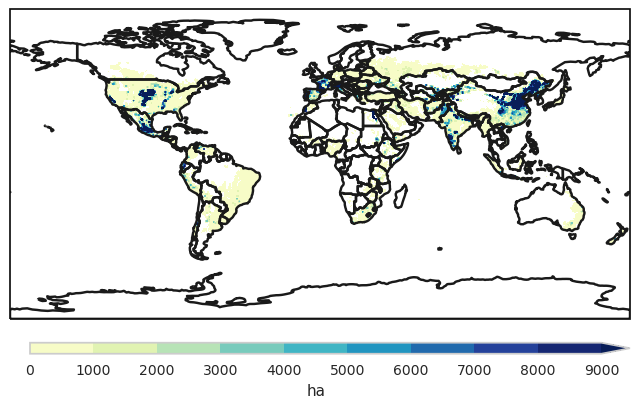

In [189]:
HA_grid = np.loadtxt('/Net/Groups/BGI/scratch/yt/data/harvested_area_grids/annual_area_harvested_irc_crop02_ha_30mn.asc', skiprows=6)
a = np.zeros_like(LON_era5)


a[::2,::2]=HA_grid[:,:]
a[::2,1::2]=HA_grid[:,:]

a[1::2,::2]=HA_grid[:,:]
a[1::2,1::2]=HA_grid[:,:]


a[a<=0]=np.nan

area = copy.deepcopy(a)

import regionmask

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.arange(0,10000,1000),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.arange(0,10000,1000))
cbar.set_label('ha')
#cbar.set_xticks(levels=np.hstack([10,np.arange(100,1100,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
#plt.colorbar(con)
area_h = copy.deepcopy(a)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
ax.spines['geo'].set_color('k')
# f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/harvest_area.jpg', dpi=300)

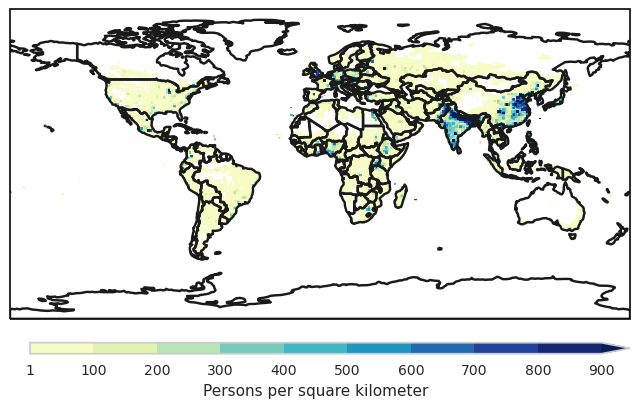

In [190]:
import regionmask
NCname = r'/Net/Groups/BGI/scratch/yt/data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_1_deg_nc/gpw_v4_population_density_adjusted_rev11_1_deg.nc'
NCData = Dataset(NCname)
lon_PD = NCData.variables['longitude'][:]
lat_PD = NCData.variables['latitude'][:]
LON_PD, LAT_PD = np.meshgrid(lon_PD, lat_PD)
PD = NCData.variables['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree'][:]
PD[PD<0] = np.nan

a = np.zeros_like(LON_era5)


a[::4,::4]=PD[4][:,:]
a[::4,1::4]=PD[4][:,:]
a[::4,2::4]=PD[4][:,:]
a[::4,3::4]=PD[4][:,:]

a[1::4,::4]=PD[4][:,:]
a[1::4,1::4]=PD[4][:,:]
a[1::4,2::4]=PD[4][:,:]
a[1::4,3::4]=PD[4][:,:]

a[2::4,::4]=PD[4][:,:]
a[2::4,1::4]=PD[4][:,:]
a[2::4,2::4]=PD[4][:,:]
a[2::4,3::4]=PD[4][:,:]

a[3::4,::4]=PD[4][:,:]
a[3::4,1::4]=PD[4][:,:]
a[3::4,2::4]=PD[4][:,:]
a[3::4,3::4]=PD[4][:,:]


a[a<1]=np.nan
a[land_mask<0.1]=np.nan

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.hstack([1,np.arange(100,1000,100)]),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.hstack([1,np.arange(100,1000,100)]))
cbar.set_label('Persons per square kilometer')
#cbar.set_xticks(levels=np.hstack([1,np.arange(100,1000,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
area_p = copy.deepcopy(a)
ax.spines['geo'].set_color('k')
# f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/population_density.jpg', dpi=300)

In [191]:
area_land = np.nansum(area_weight[land_mask>0.3])

In [192]:
area_in0 = np.array([np.nansum(area_weight[(i>0)]) for i in label_map_part2-label_map_part1])/area_land*100
area_in1 = np.array([np.nansum(area_weight[(i>j*1)]) for i,j in zip(label_map_part2,label_map_part1)])/area_land*100
area_in2 = np.array([np.nansum(area_weight[(i>j*2)]) for i,j in zip(label_map_part2,label_map_part1)])/area_land*100
area_in3 = np.array([np.nansum(area_weight[(i>j*3)]) for i,j in zip(label_map_part2,label_map_part1)])/area_land*100

In [193]:
print(area_in0)
print(area_in1)
print(area_in2)
print(area_in3)

[60.13265052 67.29976872 60.82522289 51.61405996]
[60.13265052 67.29976872 60.82522289 51.61405996]
[50.7689729  54.89150115 50.75097002 43.40620806]
[44.76898579 46.32845371 44.11678946 38.45025255]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


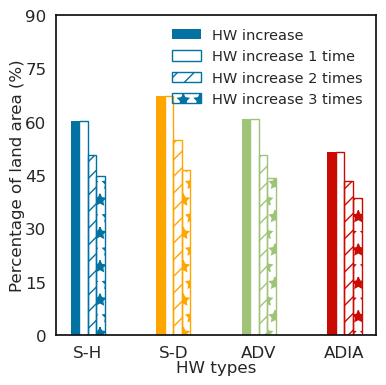

In [194]:

fig= plt.figure(figsize=(4, 4))
ax = plt.axes([0.15, 0.15, 0.8, 0.8])

ax.bar(1-0.15,area_in0[0] ,label='HW increase',color='b',width=0.1)
ax.bar(1-0.05,area_in1[0] ,label='HW increase 1 time',width=0.1,edgecolor='b',linewidth =1,facecolor = 'none')
ax.bar(1+0.05,area_in2[0],label='HW increase 2 times' ,width=0.1 ,edgecolor='b',linewidth =1,facecolor = 'none',hatch='//')
ax.bar(1+0.15,area_in3[0],label='HW increase 3 times' ,width=0.1 ,edgecolor='b',linewidth =1,facecolor = 'none',hatch='*')

for loc_temp, c in zip(np.arange(1,5)[1:],['b','orange','g','r'][1:]):
    ax.bar(loc_temp-0.15,area_in0[loc_temp-1] ,color=c,width=0.1)
    ax.bar(loc_temp-0.05,area_in1[loc_temp-1] ,width=0.1,edgecolor=c,linewidth =1,facecolor = 'none')
    ax.bar(loc_temp+0.05,area_in2[loc_temp-1],width=0.1 ,edgecolor=c,linewidth =1,facecolor = 'none',hatch='//')
    ax.bar(loc_temp+0.15,area_in3[loc_temp-1],width=0.1 ,edgecolor=c,linewidth =1,facecolor = 'none',hatch='*')

ax.set_xticks(range(1,5))
ax.set_yticks(range(0,100,15))
ax.set_yticklabels(range(0,100,15),fontsize=12)
ax.set_xticklabels(['S-H','S-D','ADV','ADIA'],fontsize=12)
ax.set_ylabel('Percentage of land area (%)',labelpad=0.1,fontsize=12)
ax.set_xlabel('HW types',labelpad=0.1,fontsize=12)
ax.set_ylim(0,90)


for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.grid(None)
plt.legend(fontsize=10.5)
# fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/changes_increase.jpg', dpi=300)

In [212]:
area_land = np.nansum(area_weight[land_mask>0.3])

In [213]:
label_map_part3 = []

for i_label in label_name:
    con_value1 = copy.deepcopy(label_map_part1[i_label])/2.1
    con_value2 = copy.deepcopy(label_map_part2[i_label])/2.1
    con_value = con_value2-con_value1
    con_value[con_value1>0]=np.nan
    # else:
    #     con_value = copy.deepcopy(label_map_part1[2]+label_map_part1[3])*0
    con_value[LAT_era5<-60]=np.nan
    con_value[land_mask<0.1]=np.nan
    # con_value[con_value<=2]=np.nan
    # con_value[con_value>2]=1
    label_map_part3.append(con_value)

In [289]:
area_new1  = np.array([np.nansum(area_weight[(i>0)]) for i in label_map_part3])/area_land*100
# area_new2  = np.array([np.nansum(area_weight[(i>j*2)]) for i,j in zip(label_map_part3,label_map_part1)])
# area_new3  = np.array([np.nansum(area_weight[(i>j*3)]) for i,j in zip(label_map_part3,label_map_part1)])
area_new2  = np.array([np.nansum(area_weight[(i>0)&(area_p>0)]) for i in label_map_part3])/np.nansum(area_weight[(area_p>0)])*100
area_new3  = np.array([np.nansum(area_weight[(i>0)&(area_h>0)]) for i in label_map_part3])/np.nansum(area_weight[(area_h>0)])*100

/tmp/ipykernel_1063836/2317431415.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,40,5),fontsize=12)


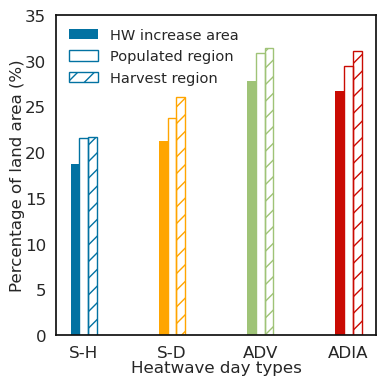

In [291]:

fig= plt.figure(figsize=(4, 4))
ax = plt.axes([0.15, 0.15, 0.8, 0.8])


ax.bar(1-0.1,area_new1[0] ,label='HW increase area',color='b',width=0.1)
ax.bar(1,area_new2[0] ,label='Populated region',width=0.1,edgecolor='b',linewidth =1,facecolor = 'none')
ax.bar(1+0.1,area_new3[0],label='Harvest region' ,width=0.1 ,edgecolor='b',linewidth =1,facecolor = 'none',hatch='//')

for loc_temp, c in zip(np.arange(1,5)[1:],['b','orange','g','r'][1:]):
    ax.bar(loc_temp-0.1,area_new1[loc_temp-1] ,color=c,width=0.1)
    ax.bar(loc_temp,area_new2[loc_temp-1] ,width=0.1,edgecolor=c,linewidth =1,facecolor = 'none')
    ax.bar(loc_temp+0.1,area_new3[loc_temp-1],width=0.1 ,edgecolor=c,linewidth =1,facecolor = 'none',hatch='//')

ax.set_xticks(range(1,5))
ax.set_xticklabels(['S-H','S-D','ADV','ADIA'],fontsize=12)
ax.set_yticklabels(range(0,40,5),fontsize=12)
ax.set_ylabel('Percentage of land area (%)',labelpad=0.1,fontsize=12)
ax.set_xlabel('Heatwave day types',labelpad=0.1,fontsize=12)
ax.set_ylim(0,35)


for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.grid(None)
plt.legend(fontsize=10.5)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_revise/changes_new_HW.jpg', dpi=300)

In [292]:
print(area_new1)
print(area_new2)
print(area_new3)


[18.74157663 21.27913313 27.84727219 26.685577  ]
[21.5797897  23.73510649 30.80865434 29.38780165]
[21.65836691 26.08888186 31.3688172  31.0503273 ]
